In [1]:
import pandas as pd
import numpy as np
import altair as alt
import vega_datasets
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.colors as mcolors


# Data Cleaning

In [2]:
#importing birth/death rate data
births_and_deaths = pd.read_csv('birth-rate-vs-death-rate.csv')

births_and_deaths.where(births_and_deaths.Code.apply(lambda x: len(str(x))) != 3).dropna(how='all').iloc[:, 5]

total_size = len(births_and_deaths)

#importing iso data
iso = pd.read_csv('slim-3.csv')

#dropped columns with null Birth rate
births_and_deaths = births_and_deaths.where(births_and_deaths.loc[:,'Birth rate, crude (per 1,000 people)'].isna() == False).dropna(how = 'all')

#dropped columns with null Death rate
births_and_deaths = births_and_deaths.where(births_and_deaths.loc[:,'Death rate, crude (per 1,000 people)'].isna() == False).dropna(how='all')

#checking to see how dropping null birth/death rate values alters size
percent_dropped = 1 - (len(births_and_deaths) / total_size)
percent_dropped

#dropped columns where 'Code' is prefixed with 'OWID'
births_and_deaths = births_and_deaths.where(births_and_deaths.Code.apply(lambda x: len(str(x))) == 3).dropna(how='all')

#checking to see that dropping OWID-prefixed data alters size 
percent_dropped = 1 - (len(births_and_deaths) / total_size)
percent_dropped

iso.columns = ['Entity', 'Code', 'country-code']

iso.where(iso.Entity == 'United Kingdom of Great Britain and Northern Ireland').dropna(how='all')

#merging data with iso code, as entity name varies (see above)
births_and_deaths = pd.merge(left = births_and_deaths, right = iso, on = ['Code'])
births_and_deaths.drop('Entity_y', axis=1, inplace = True)
births_and_deaths['Entity'] = births_and_deaths['Entity_x']
births_and_deaths.drop('Entity_x', axis=1, inplace = True)

In [3]:
births_and_deaths.Year.isna().sum()

0

In [4]:
# Locating Continents and Z-scaling birth and death rates for each.
earliest = births_and_deaths.where(births_and_deaths.Year == min(births_and_deaths.Year)).dropna(how='all')

latest = births_and_deaths.where(births_and_deaths.Year == max(births_and_deaths.Year)).dropna(how='all')

slider = alt.binding_range(min=min(births_and_deaths.Year), max=max(births_and_deaths.Year), step=1, name='Year :')

selector = alt.selection_single(
    name="SelectorName", 
    fields=['Year'],
    bind=slider,
    resolve='global'
)
#selector = alt.selection_multi(fields=['Year'], init=[{'Year': 1960}])

/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


In [5]:
#selector = alt.selection_single(name="SelectorName", fields=['Year'],
#                                bind=slider)

#highlight = alt.selection_single(on="mouseover", empty='none') 

In [6]:
from scipy.stats import zscore

In [7]:
#selecting data from df
europe = births_and_deaths.where(births_and_deaths.Code.apply(lambda x: x in ['ALB', 'AND', 'AUT', 'BLR', 'BEL', 'BIH', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FRO', 'FIN', 'FRA', 'DEU','GBR' ,'GIB', 'GRC', 'HUN', 'ISL', 'IRL', 'IMN', 'ITA', 'XKX', 'LVA', 'LIE', 'LTU', 'LUX', 'MKD', 'MLT', 'MDA', 'MCO', 'MNE', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'RUS', 'SMR', 'SRB', 'SVK', 'SVN', 'ESP', 'SWE', 'CHE', 'UKR', 'GBR', 'VAT', 'RSB'])).dropna(how='all')

In [8]:
#standardizing the birth rate to maintain base-level of comparison
europe['birth_zscore'] = europe.groupby('Year')['Birth rate, crude (per 1,000 people)'].transform(lambda x: zscore(x))
europe['death_zscore'] = europe.groupby('Year')['Death rate, crude (per 1,000 people)'].transform(lambda x: zscore(x))

In [9]:
#sanity checking whether the zscore is actually scaling by year and not generally over all years
europe.where(europe.Year == 2001).dropna(how='all').birth_zscore.idxmax()

98

In [10]:
#actually z-scaling on groups based on year
europe.where(europe.Year == 2001).dropna(how='all').loc[:, 'Birth rate, crude (per 1,000 people)'].idxmax()

98

In [11]:
#Chloropleth 1960 - 2016 tooltips, slider with frames - for Europe (reduces size of dataset - altair can only handle < 5000)

# Choropleth maps w/ tooltips and slider for the year

## Europe

In [12]:
from vega_datasets import data
sphere = alt.sphere()
graticule = alt.graticule()

source = alt.topo_feature(data.world_110m.url, feature='countries')
#Choropleth using altair with tooltips, repeated view based on birth+death rate
variable_list = ['birth_zscore', 'death_zscore']
chart_europe = alt.layer(
    alt.Chart(sphere).mark_geoshape(fill='lightblue'),
    alt.Chart(graticule).mark_geoshape(stroke='black', strokeWidth=0.5),
    alt.Chart(source).mark_geoshape(fill='white', stroke='black'),
    alt.Chart(europe).mark_geoshape().encode(color = alt.Color(alt.repeat('column'), type='quantitative'), tooltip = alt.Tooltip('Entity')).transform_lookup(
        lookup='country-code',
        from_=alt.LookupData(source, key='id', fields=["type", "properties", "geometry"])
    ).add_selection(selector).transform_filter(selector)
).project(
    type = 'mercator',
    scale = 180,
    center = [-60,68],
    clipExtent= [[0, 20], [600, 600]]
).repeat(column = variable_list).resolve_scale(color = 'independent')


/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


In [13]:
chart_europe

/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.RepeatChart(...)

## North America

In [14]:
#selecting data from df 
north_america = births_and_deaths.where(births_and_deaths.Code.apply(lambda x: x in ['AIA', 'ATG', 'ABW', 'BHS', 'BRB', 'BLZ', 'BMU', 'BES', 'VGB', 'CAN', 'CYM', 'CRI', 'CUB', 'CUW', 'DMA', 'DOM', 'SLV', 'GRL', 'GRD', 'GLP', 'GTM', 'HTI', 'HND', 'JAM', 'MTQ', 'MEX', 'SPM', 'MSR', 'ANT', 'KNA', 'NIC', 'PAN', 'PRI', 'BES', 'SXM', 'KNA', 'LCA', 'SPM', 'VCT', 'TTO', 'TCA', 'USA', 'VIR'])).dropna(how='all')

In [15]:
#zscaling for every year
north_america['birth_zscore'] = north_america.groupby('Year')['Birth rate, crude (per 1,000 people)'].transform(lambda x: zscore(x))
north_america['death_zscore'] = north_america.groupby('Year')['Death rate, crude (per 1,000 people)'].transform(lambda x: zscore(x))

In [16]:
#Choropleth using altair with tooltips, repeated view based on birth+death rate
chart_NA = alt.layer(
    alt.Chart(sphere).mark_geoshape(fill='lightblue'),
    alt.Chart(graticule).mark_geoshape(stroke='black', strokeWidth=0.5),
    alt.Chart(source).mark_geoshape(fill='white', stroke='black'),
    alt.Chart(north_america).mark_geoshape().encode(color = alt.Color(alt.repeat('column'), type='quantitative'), tooltip = alt.Tooltip('Entity')).transform_lookup(
        lookup='country-code',
        from_=alt.LookupData(source, key='id', fields=["type", "properties", "geometry"])
    ).add_selection(selector).transform_filter(selector)
).project(
    type = 'mercator',
    scale = 200,
    center = [-150,65],
    clipExtent= [[0, 20], [600, 600]]
).repeat(column = variable_list).resolve_scale(color = 'independent')

/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


In [17]:
chart_NA 

/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.RepeatChart(...)

## South America

In [18]:
#selecting the countries
south_america = births_and_deaths.where(births_and_deaths.Code.apply(lambda x: x in ['ARG','BOL', 'BRA', 'CHL', 'COL', 'ECU', 'FLK', 'GUF', 'GUY', 'PRY', 'PER', 'SUR', 'URY', 'VEN'])).dropna(how='all')

In [19]:
#zscaling
#zscaling for every year
south_america['birth_zscore'] = south_america.groupby('Year')['Birth rate, crude (per 1,000 people)'].transform(lambda x: zscore(x))
south_america['death_zscore'] = south_america.groupby('Year')['Death rate, crude (per 1,000 people)'].transform(lambda x: zscore(x))

In [20]:
#Choropleth using altair with tooltips, repeated view based on birth+death rate
chart_SA = alt.layer(
    alt.Chart(sphere).mark_geoshape(fill='lightblue'),
    alt.Chart(graticule).mark_geoshape(stroke='black', strokeWidth=0.5),
    alt.Chart(source).mark_geoshape(fill='white', stroke='black'),
    alt.Chart(south_america).mark_geoshape().encode(color = alt.Color(alt.repeat('column'), type='quantitative'), tooltip = alt.Tooltip('Entity')).transform_lookup(
        lookup='country-code',
        from_=alt.LookupData(source, key='id', fields=["type", "properties", "geometry"])
    ).add_selection(selector).transform_filter(selector)
).project(
    type = 'mercator',
    scale = 190,
    center = [-120,20],
    clipExtent= [[0, 20], [600, 600]]
).repeat(column = variable_list).resolve_scale(color = 'independent')

/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


In [21]:
chart_SA

/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.RepeatChart(...)

## Africa

In [22]:
african_iso = ['DZA','AGO','SHN','BEN','BWA','BFA','BDI','CMR','CPV','CAF','TCD','COM','COG',
'COD','DJI','EGY','GNQ','ERI','SWZ','ETH','GAB','GMB','GHA','GIN','GNB','CIV','KEN','LSO','LBR','LBY','MDG','MWI','MLI','MRT','MUS','MYT','MAR','MOZ','NAM','NER','NGA','STP','REU','RWA','STP','SEN','SYC','SLE','SOM','ZAF','SSD','SHN','SDN','SWZ','TZA','TGO','TUN','UGA','COD','ZMB','TZA','ZWE']

In [23]:
#selecting the countries
africa = births_and_deaths.where(births_and_deaths.Code.apply(lambda x: x in african_iso)).dropna(how='all')

In [24]:
#zscaling
#zscaling for every year
africa['birth_zscore'] = africa.groupby('Year')['Birth rate, crude (per 1,000 people)'].transform(lambda x: zscore(x))
africa['death_zscore'] = africa.groupby('Year')['Death rate, crude (per 1,000 people)'].transform(lambda x: zscore(x))

In [25]:
#Choropleth using altair with tooltips, repeated view based on birth+death rate
chart_AF = alt.layer(
    alt.Chart(sphere).mark_geoshape(fill='lightblue'),
    alt.Chart(graticule).mark_geoshape(stroke='black', strokeWidth=0.5),
    alt.Chart(source).mark_geoshape(fill='white', stroke='black'),
    alt.Chart(africa).mark_geoshape().encode(color = alt.Color(alt.repeat('column'), type='quantitative'), tooltip = alt.Tooltip('Entity')).transform_lookup(
        lookup='country-code',
        from_=alt.LookupData(source, key='id', fields=["type", "properties", "geometry"])
    ).add_params(selector).transform_filter(selector)
).project(
    type = 'mercator',
    scale = 200,
    center = [-30,42],
    clipExtent= [[0, 20], [600, 600]]
).repeat(column = variable_list).resolve_scale(color = 'independent')

In [26]:
chart_AF #rwanda genocide in 1995 (missing = algeria, somalia?)

/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.RepeatChart(...)

## Asia

In [27]:
#importing asian iso codes
asian_iso = pd.read_csv('asia_iso.csv')

In [28]:
#selecting the countries
asia = births_and_deaths.where(births_and_deaths.Code.apply(lambda x: x in list(asian_iso.iloc[1:,2]))).dropna(how='all')

In [29]:
#zscaling
#zscaling for every year
asia['birth_zscore'] = asia.groupby('Year')['Birth rate, crude (per 1,000 people)'].transform(lambda x: zscore(x))
asia['death_zscore'] = asia.groupby('Year')['Death rate, crude (per 1,000 people)'].transform(lambda x: zscore(x))

In [30]:
#Choropleth using altair with tooltips, repeated view based on birth+death rate
chart_AS = alt.layer(
    alt.Chart(sphere).mark_geoshape(fill='lightblue'),
    alt.Chart(graticule).mark_geoshape(stroke='black', strokeWidth=0.5),
    alt.Chart(source).mark_geoshape(fill='white', stroke='black'),
    alt.Chart(asia).mark_geoshape().encode(color = alt.Color(alt.repeat('column'), type='quantitative'), tooltip = alt.Tooltip('Entity')).transform_lookup(
        lookup='country-code',
        from_=alt.LookupData(source, key='id', fields=["type", "properties", "geometry"])
    ).add_selection(selector).transform_filter(selector)
).project(
    type = 'mercator',
    scale = 180,
    center = [30,62],
    clipExtent= [[0, 20], [600, 600]]
).repeat(column = variable_list).resolve_scale(color = 'independent')

/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


In [31]:
chart_AS #(missing = syria, cambodian genocide 1977) 

/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.RepeatChart(...)

# Non-contiguous map

In [32]:
#From 1990 - 2016 non-contiguos cartogram. scale = pop. size, color = more_births vs more_deaths

In [33]:
import geopandas

In [34]:
import geoplot

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/envs/test-env/share/proj failed


In [35]:
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)

/tmp/ipykernel_155932/7681758.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')


In [36]:
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [37]:
#selecting geodata for every continent
NA_cart = world.query('continent == "North America"')
SA_cart = world.query('continent == "South America"')
AF_cart = world.query('continent == "Africa"')
EU_cart = world.query('continent == "Europe"')
AS_cart = world.query('continent == "Asia"')

In [38]:
#selecting data for every continent for the year 2016
africa_2016 = africa.where(africa.Year == 2016).dropna(how='all')
asia_2016 = asia.where(asia.Year == 2016).dropna(how='all')
north_america_2016 = north_america.where(north_america.Year == 2016).dropna(how='all')
south_america_2016 = south_america.where(south_america.Year == 2016).dropna(how='all')
europe_2016 = europe.where(europe.Year == 2016).dropna(how='all')

In [39]:
#merging geodata with own data 
merged = pd.merge(AF_cart, africa_2016,left_on='iso_a3', right_on='Code')

## Breakdown of demographic trends by continent

In [40]:
# Using direct import method
from custom_cartogram import plot_choropleth, plot_polygon

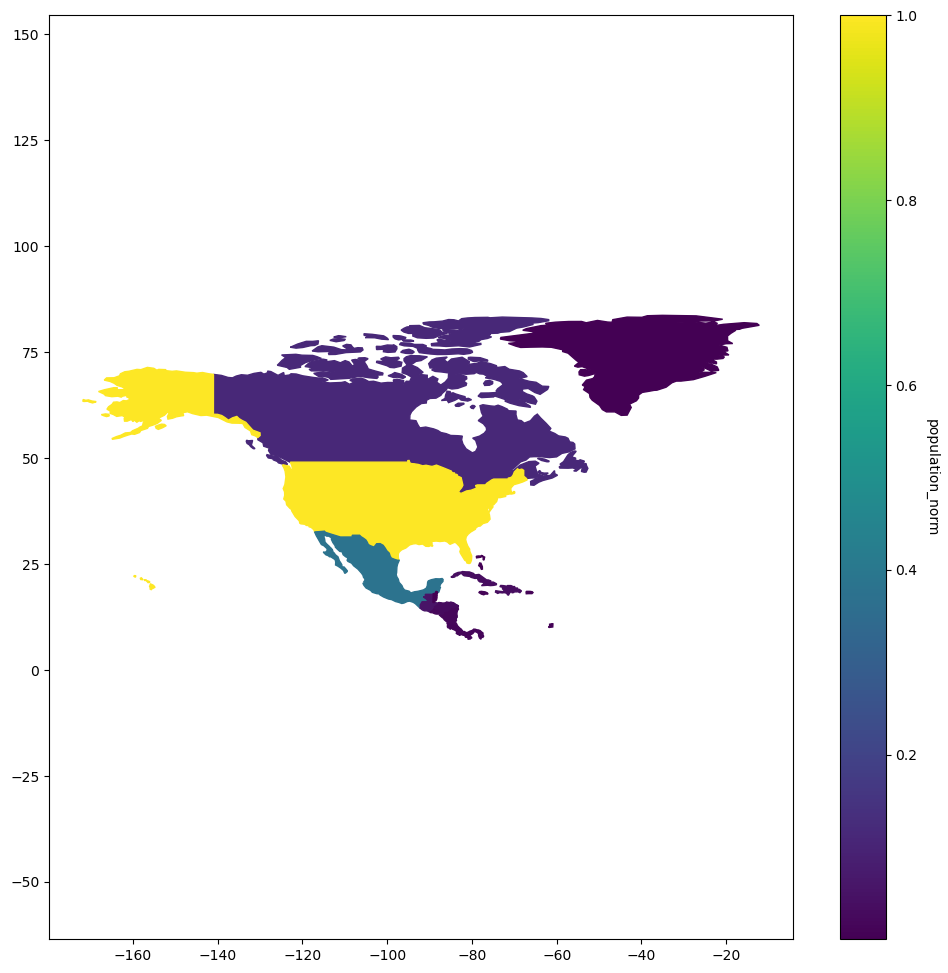

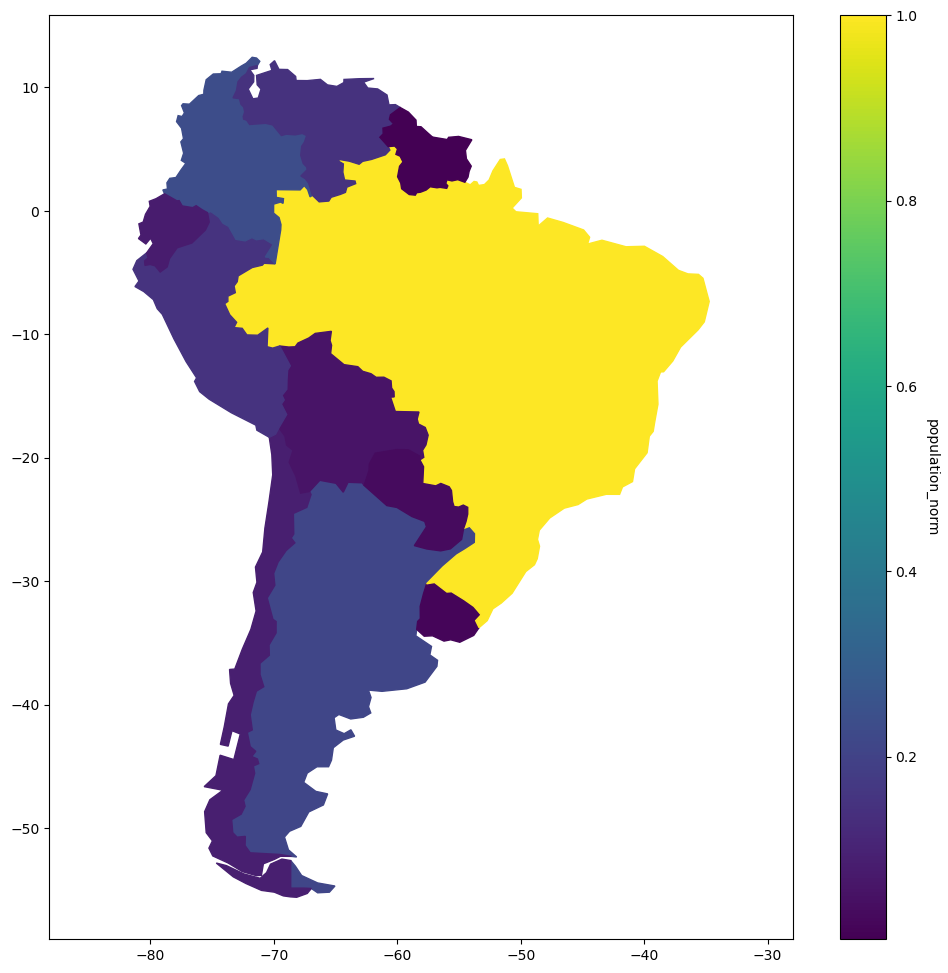

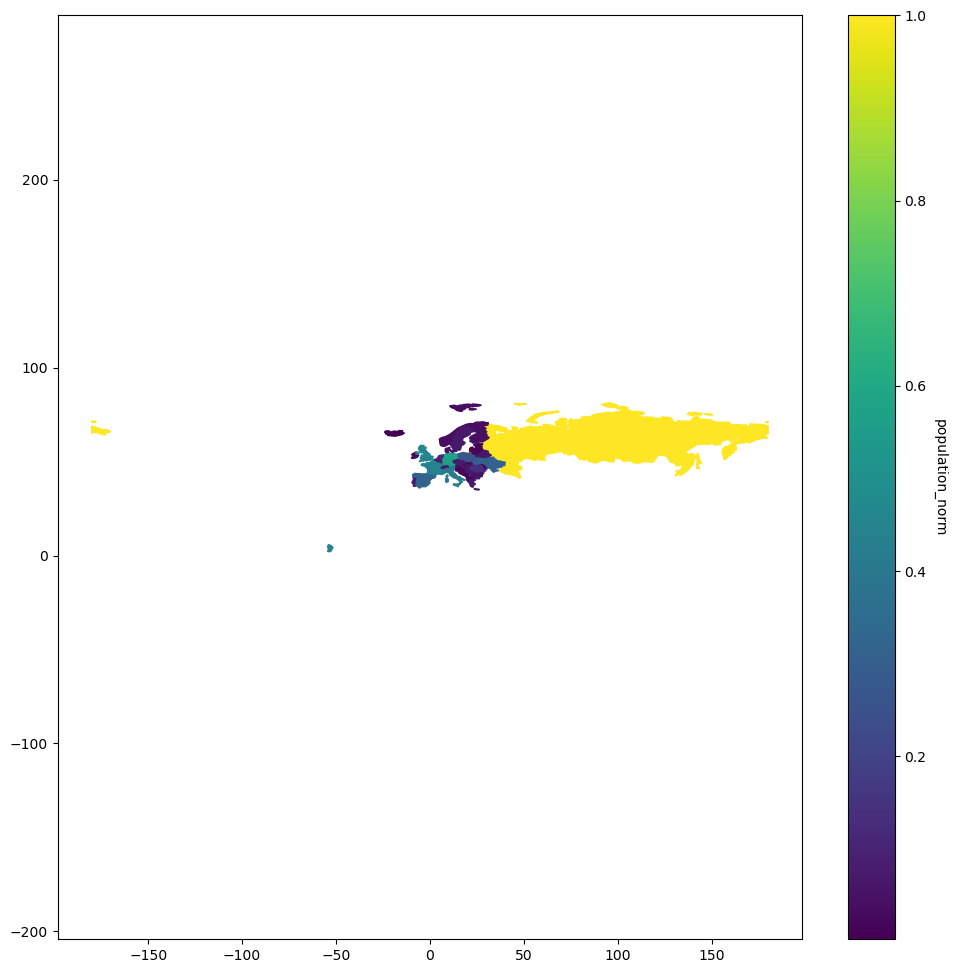

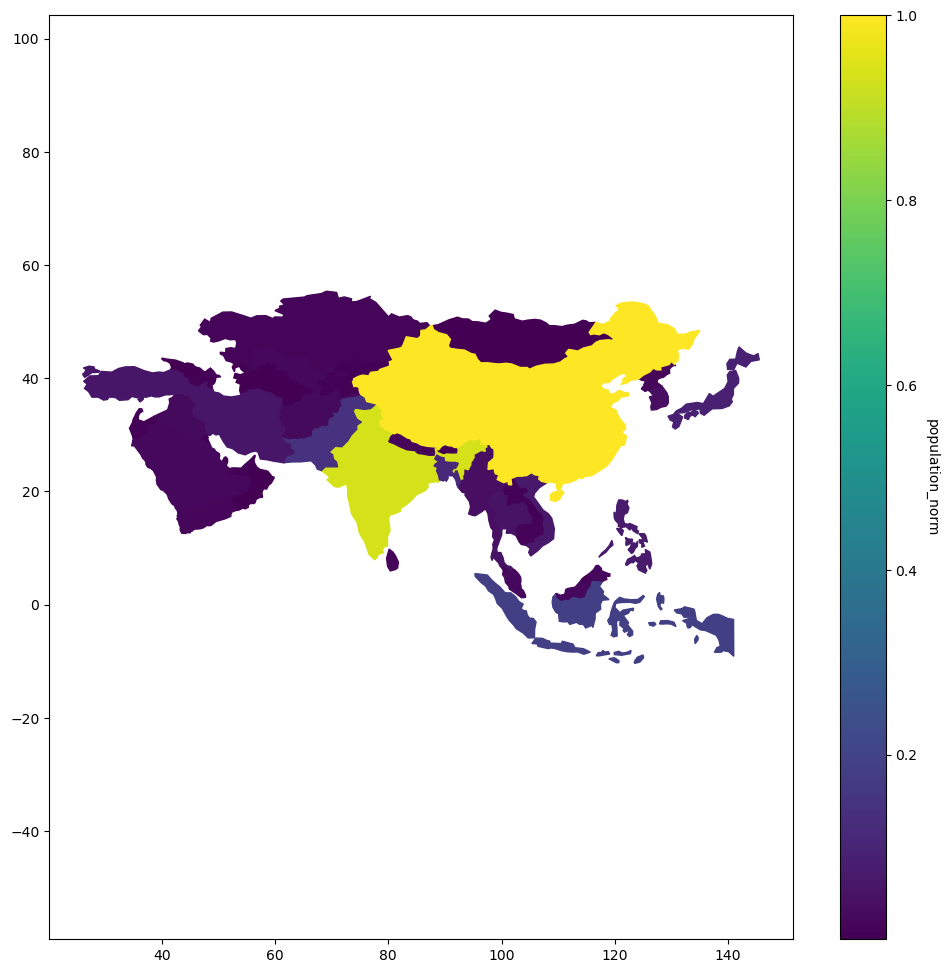

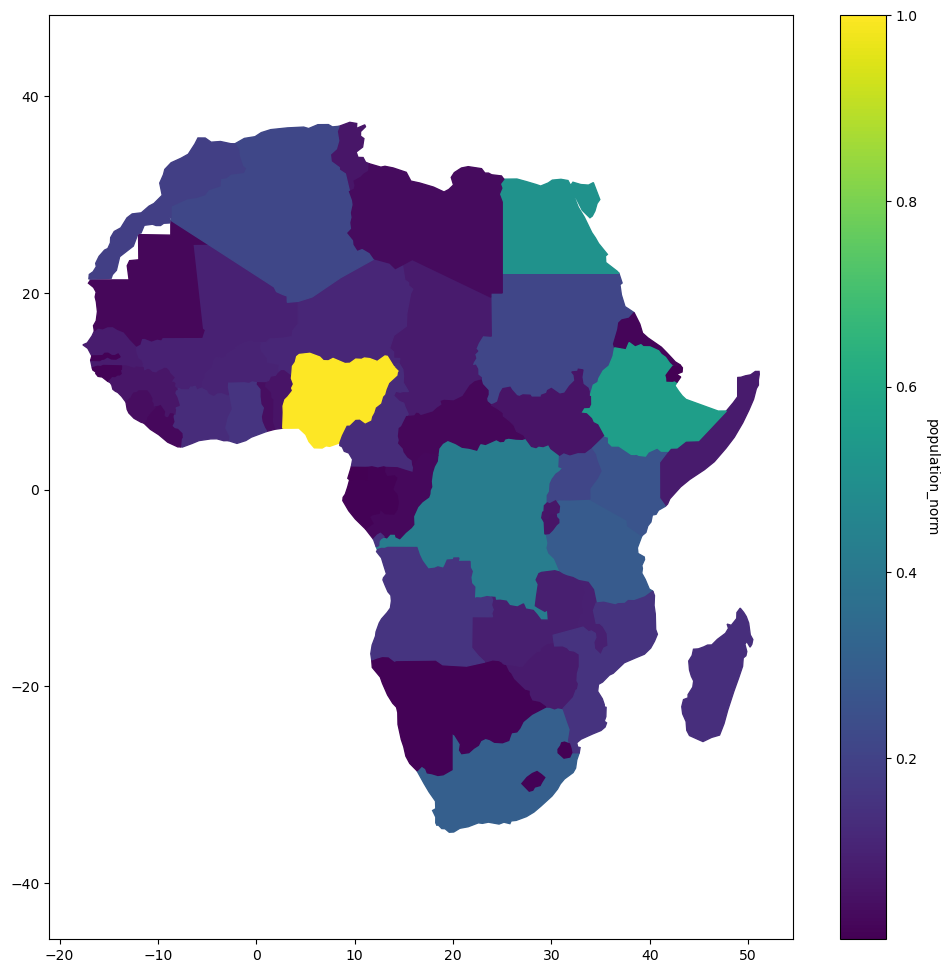

In [41]:
#plotting the charts iteratively
num = 0
fig_size = (7,9)
plots = []

# Example usage
for i in zip([NA_cart, SA_cart, EU_cart, AS_cart, AF_cart], 
             [north_america_2016, south_america_2016, europe_2016, asia_2016, africa_2016]):

    #creating color/hue attrbs (determining if birth > death, normalized)
    i[1]['birth_or_death'] = i[1].birth_zscore > i[1].death_zscore
    i[1]['birth_or_death'] = i[1]['birth_or_death'].apply(lambda x: 'More Births' if x == True else 'More Deaths')
    
    #merging our data to geodata and plotting
    merged = pd.merge(i[0], i[1], left_on='iso_a3', right_on='Code')
    
    # You might want to normalize 'Total population (Gapminder, HYDE & UN)' for coloring
    merged['population_norm'] = merged['Total population (Gapminder, HYDE & UN)'] / merged['Total population (Gapminder, HYDE & UN)'].max()
    
    # Plot the choropleth that uses norm population for 2016 data
    plot_choropleth(merged, 'population_norm', cmap='viridis')


    # If you want to save each plot as a separate image file, replace plt.show() with plt.savefig:
    # plt.savefig(f'choropleth_{num}.png', bbox_inches='tight')
    
    num += 1


# Trends of the most populous countries


In [53]:
#importing the data for population, birth rates, and death rates for each country
data = pd.read_csv('birth-rate-vs-death-rate.csv')


# creating a list of years frmo 1920 to 2016 to narrow down the data
years = list(range(1920, 2017, 1))

#filtering the data to the range of years from 1920-2016
years_filtered = data.loc[data['Year'].isin(years)]

#filtering down the data to the columns needed for visualization which are 
# Year, Country, and Total Population

# filtering the data only ot include the most powerful countries and ones with the largest economies
all_countries = years_filtered.loc[years_filtered['Entity'].isin(['United States','China','United Kingdom','Germany','India'])]

all_countries = all_countries[['Year', 'Entity','Total population (Gapminder, HYDE & UN)']]




## Population trends for the largest economies 

In [54]:
# Create a selection that chooses the nearest point & selects based on Year
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['Year'], empty='none')

# creates the base for the line chart for each country
line = alt.Chart(all_countries).mark_line(interpolate='basis').encode(
    x='Year:O',
    y='Total population (Gapminder, HYDE & UN):Q',
    color='Entity:N'
)

# allows the cursor to showcase the year of a data point
selectors = alt.Chart(all_countries).mark_point().encode(
    x='Year:O',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# adds in the data points (population for each country)
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# adds labels to the data points to showcase population for that year 
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Total population (Gapminder, HYDE & UN):Q', alt.value(' '))
)

# adds a rule
rules = alt.Chart(all_countries).mark_rule(color='lightblue').encode(
    x='Year:O',
).transform_filter(
    nearest
)

# combine all layers together
alt.layer(
    line, selectors, points, rules, text
).properties(
    width=800, height=400
)

/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection' is deprecated.
   Use 'selection_point()' or 'selection_interval()' instead; these functions also include more helpful docstrings.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/vegalite/v5/api.py:432: AltairDeprecationWarning: The types 'single' and 'multi' are now
        combined and should be specified using "selection_point()".
  warnings.warn(
/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/vegalite/v5/api.py:369: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/conda/envs/test-env/lib/python3.9/si

alt.LayerChart(...)

## Population distribution for most populous countries

In [55]:
#narrows down the data to the year marking the beginning of each decade for the last 100 years
# and filters it down to the world's most populous countries
decade_lst = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2016] 
countries = ['China','India','United States','United Kingdom','Germany','Japan','Indonesia','Brazil']
by_country = data.loc[data['Year'].isin(decade_lst)].loc[data['Entity'].isin(countries)]
by_country = by_country[['Year','Entity','Total population (Gapminder, HYDE & UN)']]

#creates a stacked bar chart showing the composition of the world population by each country
alt.Chart(by_country).mark_bar().encode(
    x='Year:O',
    y='Total population (Gapminder, HYDE & UN)',
    color='Entity',
    tooltip = alt.Tooltip('Total population (Gapminder, HYDE & UN)')
).properties(
    width=500, height=300
)

/opt/conda/envs/test-env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)